In [ ]:
# flexure-2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# preliminaries:
youngs_mod = 7e10  # youngs modulus [Pa]
poissons_ratio = 0.25  # poisson's ratio
gravity = 9.81  # gravity [ms-2]
rho_mantle = 3300  # mantle density [kgm-3]
rho_crust = 2700  # crust density [kgm-3]
rho_water = 1035  # water density [kgm-3]
rho_seds = 2400  # basin fill density [kgm-3]

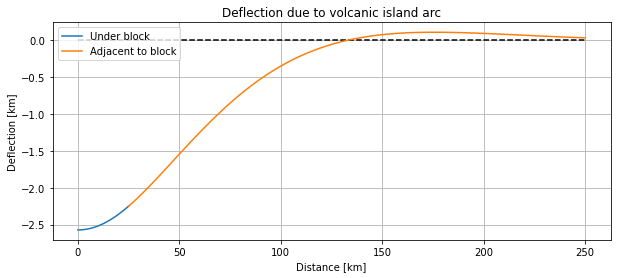

Deflection at edge of volcanic island load is -2.3 km.
Maximum deflection at origin of -2.6 km.
First node at 131.82 km.


In [2]:
# simple distributed load

length = 50 * 1000  # note this is the entire width of the island chain
height = 5 * 1000

elastic_thickness = 20 * 1000  # [m]
flexural_rigidity = (youngs_mod * (elastic_thickness ** 3)) / (
    12 * (1 - (poissons_ratio ** 2))
)
alpha = ((4 * flexural_rigidity) / ((rho_mantle - rho_water) * gravity)) ** (1 / 4)


def D1(L, h, alpha, rho_mantle, rho_load, rho_fill):
    x = np.linspace(0, L, 100)
    w = ((rho_load * h) / (2 * (rho_mantle - rho_fill))) * (
        2
        - np.exp(-(x + L) / alpha) * np.cos((x + L) / alpha)
        - np.exp(-(L - x) / alpha) * np.cos((L - x) / alpha)
    )
    return -w, x


def D2(L, h, alpha, rho_mantle, rho_load, rho_fill):
    x = np.linspace(L, 10 * L, 100)
    w = ((rho_load * h) / (2 * (rho_mantle - rho_fill))) * (
        np.exp(-(x - L) / alpha) * np.cos((x - L) / alpha)
        - np.exp(-(x + L) / alpha) * np.cos((x + L) / alpha)
    )
    return -w, x


deflection_inner, x_inner = D1(
    length / 2, height, alpha, rho_mantle, rho_crust, rho_water
)
deflection_outer, x_outer = D2(
    length / 2, height, alpha, rho_mantle, rho_crust, rho_water
)


fig = plt.figure(figsize=(10, 4))
ax = plt.axes()
ax.plot(x_inner / 1000, deflection_inner / 1000)
ax.plot(x_outer / 1000, deflection_outer / 1000)
ax.hlines(y=0, xmin=0, xmax=np.max(x_outer / 1000), linestyle="dashed", color="k")
ax.legend(["Under block", "Adjacent to block"])
ax.set_xlabel("Distance [km]")
ax.set_ylabel("Deflection [km]")
plt.title("Deflection due to volcanic island arc")
plt.grid()
plt.show()

assert deflection_inner[-1] == deflection_outer[0]
print(
    f"Deflection at edge of volcanic island load is {round(deflection_inner[-1]/1000,1)} km."
)
print(f"Maximum deflection at origin of {round(deflection_inner[0]/1000,1)} km.")
print(f"First node at {x_outer[np.abs(0 - deflection_outer).argmin()]/1000:.2f} km.")

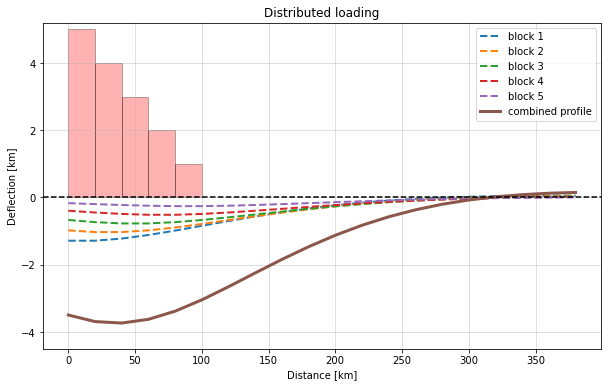

First node is at 320.0 km from origin
Basin width is 220.0 km from leading edge of shortest block.
Maximum subsidence underneath load is -3.73 km at 40.00 km from origin. 
Depth at leading edge of shortest block is -3.05 km.


In [3]:
# multi-block distributed load

# setup blocks:
width = 20 * 1000
edges = np.arange(0, 120 * 1000, width)
centres = edges[1:] - (10 * 1000)
heights = np.arange(1, 6000, 1000)[::-1]

# solve for flexural parameter alpha:
elastic_thickness = 40 * 1000  # [m]
flexural_rigidity = (youngs_mod * (elastic_thickness ** 3)) / (
    12 * (1 - (poissons_ratio ** 2))
)  # [Nm-2]
alpha = ((4 * flexural_rigidity) / ((rho_mantle - rho_seds) * gravity)) ** (
    1 / 4
)  # [m]

# calculate point loads:
Vi = np.array([(height * rho_crust * gravity * width) for height in heights])


def f(u):
    # function to take care of fourier-esque calculation:
    return np.exp(-u) * (np.cos(u) + np.sin(u))


x = np.arange(0, 20 * width, width)  # make some query points
w_array = np.ndarray((5, x.shape[0]))  # initialize an array to fill with deflections
# iteratively calculate the deflection profile for each block:
for ii in range(centres.shape[0]):
    u = np.abs(x - centres[ii]) / alpha
    w_array[ii, :] = -(Vi[ii] * f(u)) / (2 * (rho_mantle - rho_seds) * gravity * alpha)

# sum the deflection profiles from each block:
w_combined = w_array.sum(axis=0)

# plot the results:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
for ii in range(5):
    ax.plot(
        x / 1000,
        w_array[ii, :] / 1000,
        label=f"block {ii + 1}",
        linewidth=2,
        alpha=1,
        linestyle="dashed",
    )
ax.plot(x / 1000, w_combined / 1000, label="combined profile", linewidth=3)
ax.set_xlabel("Distance [km]")
ax.set_ylabel("Deflection [km]")
ax.set_ylim([-4.5, 5.2])
ax.axhline(0, color="k", linestyle="dashed")
plt.title("Distributed loading")
plt.grid(alpha=0.5)
plt.legend()
for ii in range(5):
    block = patches.Rectangle(
        (edges[ii] / 1000, 0),
        width / 1000,
        heights[ii] / 1000,
        edgecolor="k",
        facecolor="r",
        alpha=0.3,
    )
    ax.add_patch(block)
plt.show()

x0 = x[np.abs(0 - w_combined).argmin()]
print(f"First node is at {x0/1000} km from origin")
print(f"Basin width is {(x0 - edges[-1])/1000} km from leading edge of shortest block.")
print(
    f"Maximum subsidence underneath load is {w_combined.min()/1000:.2f} km at {x[np.abs(0 - w_combined).argmax()]/1000:.2f} km from origin. "
)
print(
    f"Depth at leading edge of shortest block is {w_combined[np.abs(x - edges[-1]).argmin()]/1000:.2f} km."
)